# Algoritmos de optimización

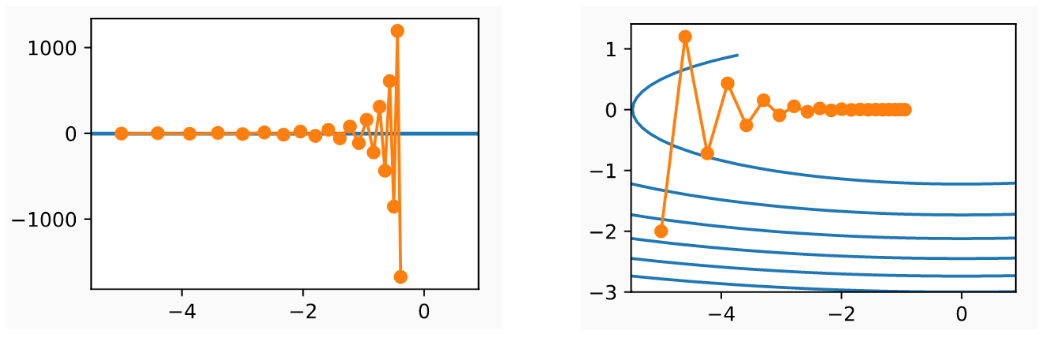

En las figuras anteriores, tenemos el recorrido que tienen los parametros de nuestro modelo luego de aplicar un optimizador. En ambos casos, el mínimo esta en $(0,0)$

Las dos figuras anteriores muestran una de las limitaciones que tiene `SGD` como optimizador. Al trabajar con una tasa de aprendizaje fija, es posible que nos encontremos en una situación donde la convergencia en una dirección sea más rápida que la otra.

A la izquierda, tenemos un caso donde en la dirección x, nuestros parametros se acercan al minimo, mientras que en la dirección y, el parametro diverge.

Por el otro lado, a la derecha tenemos otro problema. la convergencia en y es rápida, pero la convergencia en x es mucho más lenta.  

Dado que desconocemos las características de nuestras funciones de pérdida, debemos tener algun optimizador robusto que nos permita evitar este tipo de problemas, sin tener que tolerar bajas tasas de convergencia.

## Solución 1

## Tasa de aprendizaje dependiente del tiempo

Esto se corresponde a lo que se llaman schedulers o planificadores. Lo que hace esto es que para cada época, modifica el valor de la tasa de aprendizaje, empenzando primero con valores altos y luego cayendo a valores más bajos

En [está página](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) se muestran cuales son algunos de los planificadores existentes. Además alli también nos muestra como es que en general estos planificadores deben acplicarse en nuestro ciclo de entrenaminto.

```
model = [Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = SGD(model, 0.1)
scheduler = ExponentialLR(optimizer, gamma=0.9)

for epoch in range(20):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step() # luego de cada entrenamiento, debemos actualizar.
```

Entre algunos de los exitentes, tenemos planificadores con decaimiento exponencial, con disminución lineal, con función coseno, o con la posibilidad de agregar una función arbitraria.

## Solución 2

## Metodos acelerados.

## Momentum

Una segunda alternativa consiste en usar lo datos que ya tenemos de nuestra función de pérdida. Dado que constantemente estamos calculando gradientes para diferentes valores de parámetros, tal vez la información de estos gradientes puede servirnos para mejorar la convergencia de nuestro optimizador. 

El primero de estos trucos es un optimizador llamado **momentum**. Este nombre, inspirado en los momentos conjugados de la mecánica clásica. Sin perdida de la generalidad, podemos considerar la velocidad de un movil como un momento conjugado. De esta manera, el optimizador pretende imitar como una pequeña pelota cae dentro de un recipiente concavo hasta el punto más bajo. 

Para ello el optimizador hace lo siguiente:

Sean $\partial f$ el gradiente calculado, $a$ el parametro a optimizar, y $\eta$ la tasa de aprendizaje, agregamos una variables más: $v$ y un hiperparámetro $\beta$

En cada paso de actualizamos $a$ de la siguiente manera:

$$v ← \beta~v + \partial f$$
$$a ← a - \eta~v$$

El resultado es que el gradiente termina actuando como una fuerza ficticia sobre una partícula. La variable $v$ hace las veces de una velocidad ficticia y $\beta$ hace las veces de una *viscosidad* de un fluido. Desde le punto de vista estadístico, $v$ es una **media movil exponencial** es esto lo que hace que de alguna manera nuestra convergencia se acelere.

Una limitación que se ha observado es que podemos terminar volviendo al problema original. Podemos tener un problema de divergencia, solo que más rápido.

## Solución 3

## ¿Qué más podemos saber de nuestra función a minimizar?

Parte de los problemas que tenemos se deben a que la curvatura de nuestra función varía de manera distinta en distintos ejes:

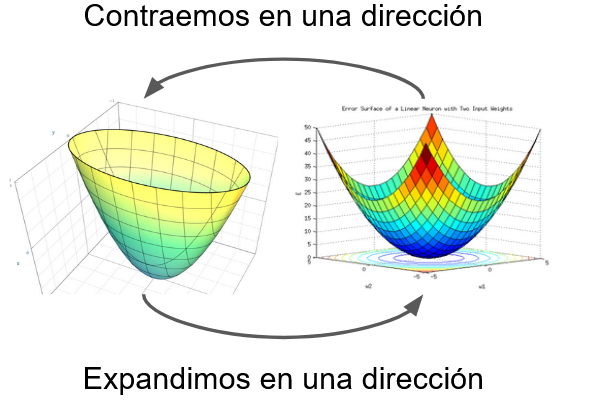

La figura de la izqueirda genera el problema que teníamos antes. En la dirección y (adelante-atras) la función es muy curvada, pero en la dirección x (izquierda-derecha) la curvatura es menor. Este es lo que nos generaba una divergencia con nuestra tasa de aprendizaje.

## Adagrad

Como la función de la izquierda tiene mayor curvatura en una dirección que en otra, es en esta dirección en donde diverge. ¿Como podemos saber que si estamos en ese caso? Si estuvieramos en ese caso, ¿que podríamos hacer para salvar el problema?

La solución natural, sería calcular el hessiano de nuestra función, pero en general esto es muy costoso computacionalmente. Una alternativa es notar que el hessiano y la curvatura están relacionados con la variabilidad de nuestro gradiente. Es decir, podemos usar la varianza o la desviación estandar del gradiente como una aproximación a nuestro hessiano. Usar este valor tiene la ventaja de que calcularla es menos costosa que el hessiano.

Por otro lado, una vez que tenemos esta cantidad podemos hacer lo que el gráfico anterior nos sugiere. Usar algun tipo de expansión o contracción que nos permita pasar de una situación con curvaturas muy distintas a curvaturas más homogeneas. Esto se conoce como "precondicionar" una matriz y es una técnica que se usa en resolución de ecuaciones lineales para acelerar la convergencia de un problema.

El algoritmo que usa esta ida se conoce como **Adagrad**

Sean $\partial f$ el gradiente calculado, $a$ el parametro a optimizar, y $\eta$ la tasa de aprendizaje, agregamos dos variables más: $s$ y $g$

En cada paso de actualizamos $a$ de la siguiente manera:

$$g ← \partial f$$
$$s ← s + g^2$$
$$a ← a - \dfrac{\eta}{\sqrt{s+\varepsilon}}~g$$

Donde $\varepsilon$ es un hiperparámetro (típicamente $10^{-6}$) para evitar dividir por $0$.

Se observa además que $s$ es una especie de varianza de nuestro gradiente. Mientras más grande es nuestra varianza, mayor curvatura tendra nuestra función de pérdida. Del mismo modo, a menor varianza, menor curvatura. Por esto es que dividimos por la raiz cuadrada de $s$ para precondicionar la matriz.

Uno de los problemas que tiene Adagrad es que ahora nuestra tasa de aprendizaje queda acomplada al gradiente:

$$\dfrac{\eta}{\sqrt{s+\varepsilon}}$$

Esto hace que nuestros intentos de usar Adagrad junto con un planificador, nos traigan problemas. Es decir, a medida que nuestras épocas pasan, el planificador disminuye nuestra tasa de aprendizaje. Pero, si $s$ dismunuye entonces ahora el factor $\frac{1}{\sqrt{s+\varepsilon}}$ puede terminar compensando la disminución o superarla. Es por esto que hay optimizadores que intentan arreglar este problema.

Antes de discutirlos, señalaremos que Torch tiene implementado Adagrad y puede ser llamado usando:

`torch.optim.Adagrad`


## RMSProp

Una de las soluciones que propone el optimizador **RMSProp** es utilizar una media movil para calcular la desviación estandar, en lugar de la desvisión estandar convencional. De esta manera, $s$ no podrá crecer de manera ilimitada

Sean $\partial f$ el gradiente calculado, $a$ el parametro a optimizar, y $\eta$ la tasa de aprendizaje, agregamos dos variables más: $s$ y $g$ y otro hiperparámetro $\gamma$

En cada paso de actualización acualizamos $a$ de la siguiente manera:

$$g ← \partial f$$
$$s ← \gamma~s + (1- \gamma)~ g^2$$
$$a ← a - \dfrac{\eta}{\sqrt{s+\varepsilon}}~g$$

El factor $(1- \gamma)$ es clave, pues es el que asegura que $s$ no crezca de manera ilimitada, a la par de que nos desacopla el gradiente de la tasa de aprendizaje

Torch tiene implementado RMSProp y puede ser llamado usando:

`torch.optim.RMSprop`

## Adadelta

Otra solución propuesta es eliminar la tasa de aprendizaje, o mejor dicho, actualizarla usando información del gradiente.

Sean $\partial f$ el gradiente calculado y $a$ el parametro a optimizar agregamos tres variables más: $s$, $\Delta a$, $g$ y $g'$ y un hiperparámetro $\rho$

En cada paso de actualización acualizamos $a$ de la siguiente manera:

$$g ← \partial f$$
$$s ← \rho~s + (1- \rho)~ g^2$$
$$a ← a - g'$$
$$g' ← \dfrac{\sqrt{\Delta a+\varepsilon}}{\sqrt{s+\varepsilon}}~g$$
$$\Delta a ← \rho ~\Delta a - (1- \rho)~ (g')^2$$

Ahora $\Delta a$ hace las veces de una tasa de aprendizaje, a la vez que nos da una información de como varian de nuestros parametros. Decimos esto, porque $\Delta a$ es una especie de varianza de $g'$ y siempre modificamos nuestros parametros $a$ con $g'$

Torch tiene implementado Adadelta y puede ser llamado usando:

`torch.optim.Adadelta`

## Adam

Adam es un algortimos de optimización que intenta usar la mayoría de las ideas anteriores. En este sentido, la propuesta de Adam es la siguiente:

Sean $\partial f$ el gradiente calculado, $a$ el parametro a optimizar y $\eta$ la tasa de aprendizaje, agregamos ocho variables más: $v$, $\hat{v}$, $s$, $\hat{s}$, $k_1$, $k_2$, $g$ y $g'$ y dos hiperparámetros $\beta_1$ y $\beta_2$

$$\begin{aligned}
    k_1 & \leftarrow k_1~\beta_1 & k_2 & \leftarrow k_2~\beta_2 \\
    v & \leftarrow \beta_1~v + (1 - \beta_1)~g, & 
    s & \leftarrow \beta_2~s + (1 - \beta_2)~g^2, \\
    \hat{v} & \leftarrow \frac{v}{1 - k_1} &
    \hat{s} & \leftarrow \frac{s}{1 - k_2}
\end{aligned}$$

$$\begin{aligned}
    g' & \leftarrow \frac{\eta v}{\sqrt{\vec{s}}+\varepsilon} \\
    a & \leftarrow a - g'
\end{aligned}$$

Por lo general se usa $\beta_1=0.9$ y $\beta_1=0.999$

Como vemos, Adam usa una media movil exponencial, $v$ para acelerar la convergencia y una varianza movil exponencial $s$ como precondicionador. Finalmente, las variables $k_1, k_2$ son usadas para evitar sesgos estadísticos en el cálculo de la media y la varianza. 

### Yogi

Sin embargo, se ha visto que en ciertos casos Adam puede fallar. Esta variante consiste en reemplazar la actualización de $s$

$$s  \leftarrow s + (1 - \beta_2)~g^2 \mathop{\mathrm{sgn}}(g^2-s)$$

Esta nueva forma de calcular $s$ es llamada **Yogi**

Torch tiene implementado Adam y puede ser llamado usando:

`torch.optim.Adam`

Intentemos minimizar ahora la siguiente función:

$$F(x,y) = x^2 + 4xy + 100y^2 - 4y + 20x + 4$$

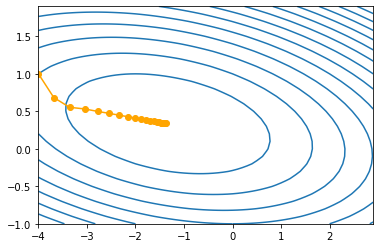

In [ ]:
import torch
import matplotlib.pyplot as plt

# funcion objetivo a minimizar
# minimo en (-4/3, 1/3)
def func(x,y):
  return x ** 2 + 2 * x * y + 10 * y ** 2 + 2 * x - 4 * y + 4


opt =  torch.optim.Adadelta
color = 'orange'

results = []


a = torch.tensor([-4.0,1.0], requires_grad=True) # inicializacion
results.append((float(a[0]),float(a[1]))) # guardamos los resultados
trainer = opt([a], lr=100) #iniciamos el optimizador
# ciclo de optimizacion
for e in range(20):
  loss = func(a[0],a[1])
  trainer.zero_grad()
  loss.backward()
  trainer.step()
  results.append((float(a[0]),float(a[1]))) # guardamos los resultados
plt.plot(*zip(*results), '-o', color=color)

## Codigo adicional para mostrar curvas de nivel
x, y = torch.meshgrid(torch.arange(-4.0, 3.0, 0.1),
                      torch.arange(-1.0, 2.0, 0.1))
levels = torch.arange(2, 80.0, 4).detach()
plt.contour(x, y, func(x, y), levels = levels,colors='#1f77b4')

Al final de esta clase esperamos que el lector pueda entender lo siguiente:

* ¿Qué es un planificador de tasa de aprendizaje?
  * ¿Como utilizaría uno?
* ¿Que es una media movil exponencial?
  * ¿Para que se usa media movil exponencial en algoritmos de optimización?
* ¿Que es una varianza movil exponencial?
  * ¿Qué ventaja tiene la varianza movil exponencial frente a la varianza?
  * ¿Para que se usa varianza movil exponencial en algoritmos de optimización?
* ¿Qué limitaciones tienen estas herramientas?



#Ejercicio

Hacer un gráfico que muestre como los diferentes optimizadores encuentran mínimos en la siguiente función:

$$F(x,y) = x^2 + 4xy + 100y^2 - 4y + 20x + 4$$

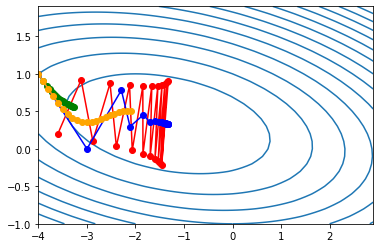

In [ ]:
import torch
import matplotlib.pyplot as plt

# funcion objetivo a minimizar
# minimo en (-4/3, 1/3)
def func(x,y):
  return x ** 2 + 2 * x * y + 10 * y ** 2 + 2 * x - 4 * y + 4

## Usar los siguientes optimizadores:
#SGD, Adagrad, RMSprop, Adam

results = [[]]
for i in range(len(opt)): #recorremos nuetros optimizacores
  pass
  # TODO
  # Inicializar a en (-4,1)
  # guardar los valores
  # inicial el optimizador
  for e in range(20):
    pass
    # TODO
    # ejecutar la optimización
    # guardar cada nuevo valor de parametros
  #graficar

## Codigo adicional para mostrar curvas de nivel
x, y = torch.meshgrid(torch.arange(-4.0, 3.0, 0.1),
                      torch.arange(-1.0, 2.0, 0.1))
levels = torch.arange(2, 80.0, 4).detach()
plt.contour(x, y, func(x, y), levels = levels,colors='#1f77b4')

## Solución

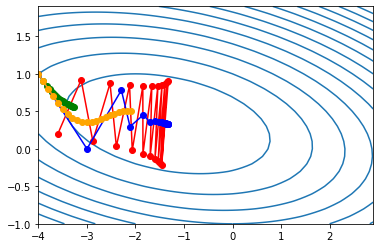

In [ ]:
import torch
import matplotlib.pyplot as plt

def func(x,y):
  return x ** 2 + 2 * x * y + 10 * y ** 2 + 2 * x - 4 * y + 4


opt = [torch.optim.SGD,
       torch.optim.Adagrad,
       torch.optim.RMSprop,
       torch.optim.Adam]
colors = ['red','green','blue','orange']
"""
opt = [torch.optim.Adadelta]
colors = ['orange']
"""

results = [[]]
for i in range(len(opt)):
  a = torch.tensor([-4.0,1.0], requires_grad=True)
  results.append([(float(a[0]),float(a[1]))])
  trainer = opt[i]([a], lr=0.1)
  for e in range(20):
    loss = func(a[0],a[1])
    trainer.zero_grad()
    loss.backward()
    trainer.step()
    results[i].append((float(a[0]),float(a[1])))
  plt.plot(*zip(*results[i]), '-o', color=colors[i])

x, y = torch.meshgrid(torch.arange(-4.0, 3.0, 0.1),
                      torch.arange(-1.0, 2.0, 0.1))
levels = torch.arange(2, 80.0, 4).detach()
plt.contour(x, y, func(x, y), levels = levels,colors='#1f77b4')